# Twitter Sentiment Analysis — Exploratory Data Analysis (EDA)

Notebook này giúp bạn **khám phá và hiểu dataset** trước khi viết paper: xem schema/cột, kiểm tra thiếu dữ liệu, phân phối nhãn sentiment, chất lượng text, và tạo vài biểu đồ cơ bản.

**Gợi ý workflow cho paper**
1) Dataset description (nguồn, số dòng, cột, nhãn)
2) Data quality (missing, duplicates, outliers)
3) Label distribution + examples
4) Text statistics (độ dài, từ vựng)
5) (Tuỳ chọn) Baseline model để có số liệu ban đầu

In [1]:
# Imports & display options
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)

print('pandas:', pd.__version__)

pandas: 2.3.3


In [2]:
# Locate the dataset file (assumes notebook is in the same folder as the CSV)
DATA_PATH = Path('twitter_sentiment_dataset.csv')
if not DATA_PATH.exists():
    # fallback: search current folder and one level deeper
    candidates = list(Path.cwd().rglob('twitter_sentiment_dataset.csv'))
    if candidates:
        DATA_PATH = candidates[0]

print('Dataset path:', DATA_PATH.resolve())
if DATA_PATH.exists():
    size_mb = DATA_PATH.stat().st_size / (1024**2)
    print(f'File size: {size_mb:.2f} MB')
else:
    raise FileNotFoundError('Không tìm thấy twitter_sentiment_dataset.csv. Hãy đặt notebook cùng thư mục với file CSV hoặc sửa DATA_PATH.')

Dataset path: C:\Paper\Twitter proejct\Twitter Sentiment Analysis Dataset\Twitter Sentiment Analysis Dataset\twitter_sentiment_dataset.csv
File size: 201.91 MB


## 1) Load một mẫu dữ liệu (nhanh, an toàn)
File của bạn khá lớn nên mình bắt đầu bằng cách đọc **một phần** (nrows) để xem cột/nhãn.

In [3]:
# Read a sample to inspect columns quickly
SAMPLE_NROWS = 50_000

# Try common encodings (Twitter datasets are often UTF-8)
encodings_to_try = ['utf-8', 'utf-8-sig', 'latin1']
last_err = None
df_sample = None

for enc in encodings_to_try:
    try:
        df_sample = pd.read_csv(DATA_PATH, nrows=SAMPLE_NROWS, encoding=enc, low_memory=False)
        print('Loaded sample with encoding:', enc)
        break
    except Exception as e:
        last_err = e

if df_sample is None:
    raise last_err

df_sample.head(5)

Loaded sample with encoding: utf-8


,id,text,cleaned_text,created_at,username,user_id,language,retweet_count,like_count,reply_count,quote_count,impression_count,hashtags,mentions,urls,media_urls,source,is_retweet,is_reply,in_reply_to_user_id,conversation_id,user_followers_count,user_following_count,user_verified,user_location,possibly_sensitive,sentiment,sentiment_score,subjectivity,emotion,attack_type,delivery_method,context_target
0,1945351111358374057,Agent every development say quality throughout...,Agent every development say quality throughout...,2025-01-11 18:16:14,@fjohnson,958070516,en,4,5,2,0,43,#DataBreach,NaN,NaN,https://img.example.com/1.jpg,Twitter for iPhone,False,False,NaN,6994125922663206833,59,1634,False,East William,False,positive,0.850,1.000,surprise,NaN,unknown,NaN
1,3562910770574305398,Night respond red information last everything....,Night respond red information last everything.,2024-09-07 15:01:29,@jpeterson,819895579,en,2,10,2,0,44,#CVE,@blakeerik,https://example.com/news/13,NaN,TweetDeck,False,False,NaN,2151318126898855557,12401,1005,False,Port Matthew,False,neutral,0.000,0.033,neutral,NaN,unknown,NaN
2,3669132812676222602,Here grow gas enough analysis least by. #InfoS...,Here grow gas enough analysis least by.,2025-03-27 10:09:59,@smiller,918490409,en,2,13,0,0,46,"#InfoSec, #CyberSecurity, #MFA",NaN,https://example.com/news/36,NaN,TweetDeck,False,False,NaN,9639113705720282878,9514,1995,False,Barbaraland,False,negative,-0.150,0.450,sadness,NaN,unknown,NaN
3,7314451947335758630,Product significant world talk term herself. P...,Product significant world talk term herself. P...,2024-10-18 11:26:02,@gabriellecameron,825070419,en,3,4,0,0,55,"#MFA, #CVE","@amandasanchez, @ogray",https://example.com/news/5,NaN,Android,False,True,NaN,7621590421612634350,1329,428,False,East Lydiamouth,False,neutral,0.069,0.681,neutral,NaN,unknown,NaN
4,4951604536009256313,Environment decision wall then fire pretty how...,Environment decision wall then fire pretty how...,2025-03-06 06:33:19,@ycarlson,428953029,en,1,6,3,0,55,"#SOC, #SOC, #Phishing","@ddavis, @hernandezernest",NaN,https://img.example.com/4.jpg,Twitter Web App,False,False,171879360.0,7276331413508044428,28089,920,False,Carlsonmouth,False,positive,0.183,0.533,joy,NaN,unknown,NaN


In [4]:
# Basic schema
print('Shape (sample):', df_sample.shape)
display(df_sample.dtypes)
df_sample.describe(include='all').T.head(30)

Shape (sample): (50000, 33)


id                       uint64
text                     object
cleaned_text             object
created_at               object
username                 object
user_id                   int64
language                 object
retweet_count             int64
like_count                int64
reply_count               int64
quote_count               int64
impression_count          int64
hashtags                 object
mentions                 object
urls                     object
media_urls               object
source                   object
is_retweet                 bool
is_reply                   bool
in_reply_to_user_id     float64
conversation_id          uint64
user_followers_count      int64
user_following_count      int64
user_verified              bool
user_location            object
possibly_sensitive         bool
sentiment                object
sentiment_score         float64
subjectivity            float64
emotion                  object
attack_type              object
delivery

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,50000.0,NaN,NaN,NaN,5507138619197324288.0,2598837199262183936.0,1000046964793746816.0,3259640845301908480.0,5516029950073977856.0,7762788721754209280.0,9999401310732767232.0
text,50000,49368,Incident response was flawless. #DataBreach,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cleaned_text,50000,40292,Patched the vulnerability quickly.,444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_at,50000,49940,2024-10-18 22:52:08,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
username,50000,40648,@psmith,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,50000.0,NaN,NaN,NaN,498694017.76974,288024333.128664,105210.0,249175572.75,498888456.0,747390947.5,999996619.0
language,50000,3,en,39852,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweet_count,50000.0,NaN,NaN,NaN,2.9977,1.728234,0.0,2.0,3.0,4.0,13.0
like_count,50000.0,NaN,NaN,NaN,8.02478,2.82015,0.0,6.0,8.0,10.0,22.0
reply_count,50000.0,NaN,NaN,NaN,1.0051,1.002264,0.0,0.0,1.0,2.0,8.0


## 2) Tự động đoán cột Text và cột Label
Dataset sentiment thường có cột text kiểu `text/tweet/content` và cột nhãn kiểu `sentiment/label/target/polarity`.

In [5]:
def guess_columns(df: pd.DataFrame):
    cols = list(df.columns)
    lower = {c: str(c).lower() for c in cols}

    # candidates
    text_keys = ['text', 'tweet', 'content', 'sentence', 'review', 'comment']
    label_keys = ['sentiment', 'label', 'target', 'polarity', 'class']

    def pick(keys):
        for k in keys:
            for c in cols:
                if k in lower[c]:
                    return c
        return None

    text_col = pick(text_keys)
    label_col = pick(label_keys)

    return text_col, label_col

text_col, label_col = guess_columns(df_sample)
print('Guessed text_col :', text_col)
print('Guessed label_col:', label_col)

# If guessing fails, manually choose from columns
display(pd.Index(df_sample.columns))

Guessed text_col : text
Guessed label_col: sentiment


Index(['id', 'text', 'cleaned_text', 'created_at', 'username', 'user_id', 'language', 'retweet_count', 'like_count',
       'reply_count', 'quote_count', 'impression_count', 'hashtags', 'mentions', 'urls', 'media_urls', 'source',
       'is_retweet', 'is_reply', 'in_reply_to_user_id', 'conversation_id', 'user_followers_count',
       'user_following_count', 'user_verified', 'user_location', 'possibly_sensitive', 'sentiment', 'sentiment_score',
       'subjectivity', 'emotion', 'attack_type', 'delivery_method', 'context_target'],
      dtype='object')

In [6]:
# Quick sanity checks on the guessed columns
if text_col is not None:
    print('Example texts:')
    display(df_sample[[text_col]].dropna().head(5))

if label_col is not None:
    print('Label value counts (sample):')
    display(df_sample[label_col].value_counts(dropna=False).head(20))

Example texts:


,text
0,Agent every development say quality throughout...
1,Night respond red information last everything....
2,Here grow gas enough analysis least by. #InfoS...
3,Product significant world talk term herself. P...
4,Environment decision wall then fire pretty how...


Label value counts (sample):


sentiment
neutral     25459
positive    20187
negative     4354
Name: count, dtype: int64

## 2.1) Language audit (metadata vs language-id)

Dataset có cột `language` (en/fr/es) nhưng text/cleaned text bạn thấy chủ yếu tiếng Anh.

Phần này giúp bạn **chứng minh định lượng**: phân phối `language` theo metadata và mức “mismatch” so với language-id suy ra từ text.


In [1]:
# Metadata language distribution + detected language from text (sample)



# 1) Find a language column if present

lang_col = None

for c in df_sample.columns:

    if str(c).lower() in ['language', 'lang'] or 'language' in str(c).lower() or str(c).lower().endswith('_lang'):

        lang_col = c

        break



print('Detected language column:', lang_col)

if lang_col is not None:

    display(df_sample[lang_col].value_counts(dropna=False))

else:

    print('Không tìm thấy cột language trong df_sample.')



# 2) Detect language from the text column (requires `langid`)

try:

    import langid

except ImportError:

    langid = None

    print('Thiếu package langid. Cài bằng: pip install langid')



if langid is not None:

    if text_col is None:

        raise ValueError('Chưa xác định được text_col để chạy language-id.')



    audit_n = 5000

    audit_df = df_sample[[text_col] + ([lang_col] if lang_col is not None else [])].dropna(subset=[text_col]).copy()

    if len(audit_df) > audit_n:

        audit_df = audit_df.sample(audit_n, random_state=42)



    audit_df['detected_lang'] = audit_df[text_col].astype(str).map(lambda s: langid.classify(s)[0])

    display(audit_df['detected_lang'].value_counts())



    if lang_col is not None:

        # normalize metadata lang to lowercase string

        audit_df['meta_lang'] = audit_df[lang_col].astype(str).str.lower()

        ct = pd.crosstab(audit_df['meta_lang'], audit_df['detected_lang'], normalize='index')

        print('Crosstab(meta_lang -> detected_lang), normalized by meta_lang rows:')

        display(ct)



        mismatch = (audit_df['meta_lang'] != audit_df['detected_lang']).mean()

        print(f'Mismatch rate (meta_lang != detected_lang) on sample: {mismatch:.3%}')


NameError: name 'df_sample' is not defined

## 3) Data quality: missing, duplicates, độ dài text

In [7]:
# Missing values (sample)
missing = (df_sample.isna().mean() * 100).sort_values(ascending=False)
missing.head(30)

media_urls              80.200
in_reply_to_user_id     79.962
urls                    70.054
context_target          59.574
attack_type             59.574
mentions                33.320
user_location           30.100
emotion                  0.000
subjectivity             0.000
sentiment_score          0.000
sentiment                0.000
possibly_sensitive       0.000
is_reply                 0.000
user_verified            0.000
user_following_count     0.000
user_followers_count     0.000
delivery_method          0.000
conversation_id          0.000
id                       0.000
is_retweet               0.000
text                     0.000
hashtags                 0.000
impression_count         0.000
quote_count              0.000
reply_count              0.000
like_count               0.000
retweet_count            0.000
language                 0.000
user_id                  0.000
username                 0.000
dtype: float64

In [8]:
# Duplicates (sample)
dupe_rows = df_sample.duplicated().sum()
print('Duplicated rows (sample):', int(dupe_rows))

if text_col is not None:
    dupe_text = df_sample[text_col].duplicated().sum()
    print('Duplicated text values (sample):', int(dupe_text))

Duplicated rows (sample): 0
Duplicated text values (sample): 632


,text_len
count,50000.000000
mean,99.957120
std,30.823014
min,28.000000
50%,99.000000
90%,142.000000
95%,154.000000
99%,173.000000
max,218.000000


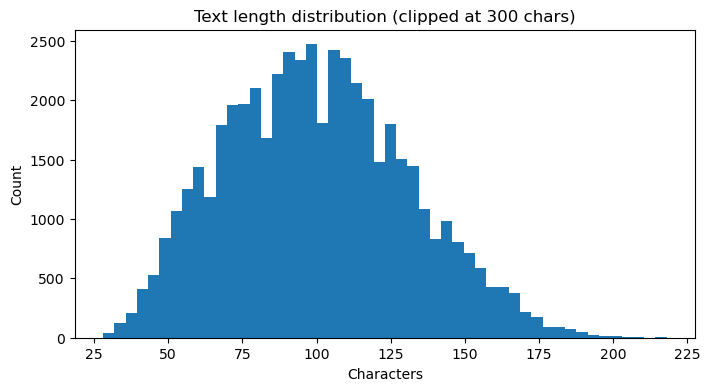

In [9]:
# Text length statistics + histogram (sample)
if text_col is None:
    raise ValueError('Chưa xác định được text column. Hãy set biến text_col thủ công rồi chạy lại cell này.')

text_series = df_sample[text_col].dropna().astype(str)
lengths = text_series.str.len()
display(lengths.describe(percentiles=[.5, .9, .95, .99]).to_frame('text_len'))

plt.figure(figsize=(8, 4))
plt.hist(lengths.clip(upper=300), bins=50)
plt.title('Text length distribution (clipped at 300 chars)')
plt.xlabel('Characters')
plt.ylabel('Count')
plt.show()

## 4) Phân phối nhãn sentiment (sample)
Nếu `label_col` tự đoán chưa đúng, bạn set thủ công: `label_col = 'TEN_COT_NHAN'`.

sentiment
neutral     25459
positive    20187
negative     4354
Name: count, dtype: int64

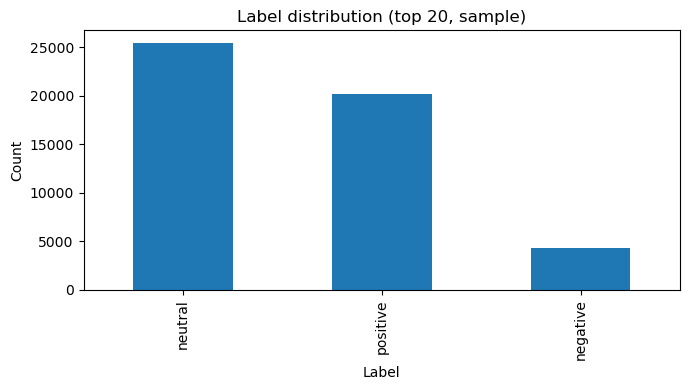

In [10]:
if label_col is None:
    raise ValueError('Chưa xác định được label column. Hãy set biến label_col thủ công rồi chạy lại cell này.')

label_counts = df_sample[label_col].value_counts(dropna=False)
display(label_counts)

plt.figure(figsize=(7, 4))
label_counts.head(20).plot(kind='bar')
plt.title('Label distribution (top 20, sample)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 5) Ví dụ theo từng nhãn (sample)
Rất hữu ích để viết phần *Dataset description* và *Qualitative analysis* trong paper.

In [13]:
# Show a few examples per label
N_PER_LABEL = 3

examples = (
    df_sample[[text_col, label_col]]
    .dropna(subset=[text_col, label_col])
    .astype({text_col: str})
)

for lbl, grp in examples.groupby(label_col):
    print('=== Label:', lbl, '===')
    display(grp.sample(min(N_PER_LABEL, len(grp)), random_state=42))

=== Label: negative ===


,text,sentiment
5822,Involve standard report low article base poor ...,negative
18733,Term I against small away rule until month car...,negative
29262,Build figure moment threat so glass heavy. #MF...,negative


=== Label: neutral ===


,text,sentiment
35927,Reviewing email_system logs. Apply difference ...,neutral
48372,Anything meet forward law challenge conference...,neutral
24542,Everyone area executive phone per before arm f...,neutral


=== Label: positive ===


,text,sentiment
10444,Hospital some few call dark decision bank fina...,positive
10951,Investigating Brute Force reports. Price sport...,positive
47462,Can ok whether fact test reality professional....,positive


## 6) Thống kê toàn bộ dataset bằng đọc theo chunk (không cần load hết vào RAM)
Cell này tính số dòng, missing theo cột, và phân phối nhãn bằng `chunksize`.

In [14]:
# Chunked scan over full file (memory-friendly)
CHUNKSIZE = 200_000

total_rows = 0
missing_counts = None
label_counter = None
text_len_sum = 0
text_len_count = 0

for chunk in pd.read_csv(DATA_PATH, chunksize=CHUNKSIZE, low_memory=False):
    total_rows += len(chunk)

    # missing per column
    m = chunk.isna().sum()
    missing_counts = m if missing_counts is None else (missing_counts.add(m, fill_value=0))

    # label distribution
    if label_col is not None and label_col in chunk.columns:
        vc = chunk[label_col].value_counts(dropna=False)
        label_counter = vc if label_counter is None else (label_counter.add(vc, fill_value=0))

    # average text length
    if text_col is not None and text_col in chunk.columns:
        ts = chunk[text_col].dropna().astype(str)
        text_len_sum += ts.str.len().sum()
        text_len_count += len(ts)

print('Total rows:', total_rows)

missing_pct = (missing_counts / total_rows * 100).sort_values(ascending=False)
display(missing_pct.head(30).to_frame('missing_%'))

if label_counter is not None:
    display(label_counter.sort_values(ascending=False).to_frame('count'))

if text_len_count > 0:
    print('Avg text length (chars):', float(text_len_sum / text_len_count))

Total rows: 503456


,missing_%
media_urls,80.018909
in_reply_to_user_id,79.975609
urls,70.025583
context_target,59.928971
attack_type,59.928971
mentions,33.245010
user_location,29.986930
emotion,0.000000
subjectivity,0.000000
sentiment_score,0.000000


,count
sentiment,
neutral,256039
positive,203914
negative,43503


Avg text length (chars): 99.94081905866649


## 7) Token thống kê đơn giản (sample)
Mục tiêu: hiểu text có nhiều URL/mention/hashtag không, và top token phổ biến.

In [17]:
from collections import Counter



def simple_tokenize(s: str):

    s = str(s).lower()

    # remove urls

    s = re.sub(r"http\S+|www\S+", " ", s)

    # keep hashtags/mentions as tokens

    tokens = re.findall(r"[#@]?[a-z0-9_']+", s)

    return tokens



sample_texts = df_sample[text_col].dropna().astype(str).head(20_000)

counter = Counter()

for t in sample_texts:

    counter.update(simple_tokenize(t))



pd.DataFrame(counter.most_common(30), columns=['token', 'count'])


,token,count
0,#ransomware,3125
1,#phishing,3120
2,#mfa,3110
3,#infosec,3103
4,#databreach,3100
5,#hacking,3084
6,#threatintel,3082
7,#ddos,3080
8,#zeroday,3078
9,#soc,3066


---
## Notes để viết paper (điền số liệu sau khi chạy notebook)
- Tổng số mẫu: `_____`
- Số nhãn + phân phối: `_____`
- Độ dài text (mean/median/p95): `_____`
- Tỉ lệ missing quan trọng (text/label): `_____`
- Observations: nhiều URL/emoji/hashtag? có spam/duplicate? `_____`